# Multi-label classifier

Обучите модель для предсказания аттрибутов по фотографии на датасете [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

**Задача**
Датасет содержит фотографий лиц. Каждая фотография характреризуется набором признаков: пол, возраст, улыбка ... всего 40 признаков

Нужно обучить модель которая будет предсказывать признаки по фотографии.
И оценить качество ее работы используя соответствующие метрики.



# Порядок выполнения задания

Задание рекомендуется выполнять по шагам:

1. Познакомьтесь с данными
2. Выберите метрику для оценки результата
3. Проведите анализ, изучите существующие модели которые можно использовать для решения задачи
4. Проведите EDA, опишите особенности данных и проблемы которые они могут за собой повлечь
5. Подготовьте данные для обучения
6. Выберите baseline модель, оцените качество её работы на данном датасете.
7. Попробуйте улучшить значение метрики используя другую модель. Возможно обучив/дообучив ее.
8. Оцените быстродействие выбранной модели
9. Дайте оценку полученному результату.

## Анализ данных (EDA)

# Загрузка данных

In [1]:
!wget https://ml.gan4x4.ru/hse/cv/gan_celeba.zip
!unzip gan_celeba.zip -d celeba

--2024-10-27 16:01:27--  https://ml.gan4x4.ru/hse/cv/gan_celeba.zip
Resolving ml.gan4x4.ru (ml.gan4x4.ru)... 212.24.105.216
Connecting to ml.gan4x4.ru (ml.gan4x4.ru)|212.24.105.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1429904993 (1.3G) [application/zip]
Saving to: ‘gan_celeba.zip.3’

gan_celeba.zip.3    100%[===================>]   1.33G  9.49MB/s    in 3m 7s   

2024-10-27 16:04:36 (7.28 MB/s) - ‘gan_celeba.zip.3’ saved [1429904993/1429904993]

Archive:  gan_celeba.zip
replace celeba/img_align_celeba/000333.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
from torchvision.datasets import CelebA

# download = True cause an error with gdown
train_dataset = CelebA(root='/content', split='train', target_type='attr', download=False) #, transform=data_transform)

Total 41 attribute

In [3]:
attr_names = train_dataset.attr_names[0:]
print("Attributes: ",", ".join(attr_names))
print(len(attr_names))

Attributes:  5_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young, 
41


Look at pictures

In [4]:
import matplotlib.pyplot as plt

# helper method
def show_images(ds, idx):
    fig, axes = plt.subplots(1, len(idx), figsize=(15, 5))
    for j, n in enumerate(idx):
        image, label = ds[n]
        axes[j].imshow(image)
        label_names = [ds.attr_names[i] for i in range(len(label)) if label[i] == 1]
        axes[j].set_title("\n".join(label_names))
        axes[j].axis('off')
    plt.show()

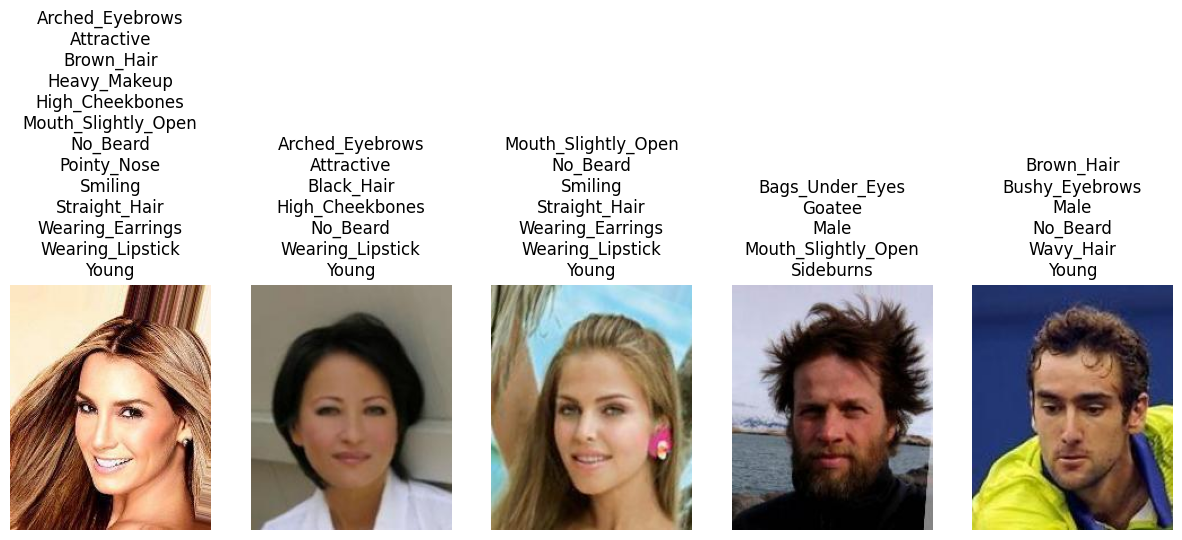

In [5]:
show_images(train_dataset, [0,100,1000,10000,100000])

## EDA



In [6]:
# длина датасета (кол-во изображений)
print("Number of samples in dataset:", len(train_dataset))

sample_image, sample_label = train_dataset[0]
print("Image shape:", sample_image.size)
print("Label shape:", sample_label.shape)
print("Number of attributes in dataset:", sample_label.shape[0])

Number of samples in dataset: 162770
Image shape: (178, 218)
Label shape: torch.Size([40])
Number of attributes in dataset: 40


In [7]:
import torch

all_labels = torch.stack([label for _, label in train_dataset])

# считаем частоту каждого атрибута
attribute_counts = all_labels.sum(dim=0).numpy()

for attr, count in zip(attr_names, attribute_counts):
    print(f"{attr}: {count}")

5_o_Clock_Shadow: 18177
Arched_Eyebrows: 43278
Attractive: 83603
Bags_Under_Eyes: 33280
Bald: 3713
Bangs: 24685
Big_Lips: 39213
Big_Nose: 38341
Black_Hair: 38906
Blond_Hair: 24267
Blurry: 8362
Brown_Hair: 33192
Bushy_Eyebrows: 23386
Chubby: 9389
Double_Chin: 7571
Eyeglasses: 10521
Goatee: 10337
Gray_Hair: 6896
Heavy_Makeup: 62555
High_Cheekbones: 73645
Male: 68261
Mouth_Slightly_Open: 78486
Mustache: 6642
Narrow_Eyes: 18869
No_Beard: 135779
Oval_Face: 46101
Pale_Skin: 7005
Pointy_Nose: 44846
Receding_Hairline: 13040
Rosy_Cheeks: 10525
Sideburns: 9156
Smiling: 78080
Straight_Hair: 33947
Wavy_Hair: 51982
Wearing_Earrings: 30362
Wearing_Hat: 8039
Wearing_Lipstick: 76437
Wearing_Necklace: 19764
Wearing_Necktie: 11890
Young: 126788


In [8]:
import numpy as np

median_frequency = np.median(attribute_counts)
print("Median frequency:", median_frequency)

# отбираем атрибуты, у которых частота выше или равна медиане:
# это позволит отфильтровать признаки, которые встречаются реже половины всех атрибутов
selected_attributes = [attr for attr, count in zip(attr_names, attribute_counts) if count >= median_frequency]
selected_indices = [attr_names.index(attr) for attr in selected_attributes]

print("Selected attributes:", selected_attributes)
print("Number of selected attributes:", len(selected_attributes))

Median frequency: 27523.5
Selected attributes: ['Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Brown_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'No_Beard', 'Oval_Face', 'Pointy_Nose', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Lipstick', 'Young']
Number of selected attributes: 20


In [9]:
# определяем класс для урезанного (в плане признаков) датасета
class FilteredCelebADataset(torch.utils.data.Dataset):
    def __init__(self, dataset, selected_indices, selected_attr_names):
        self.dataset = dataset
        self.selected_indices = selected_indices
        self.attr_names = selected_attr_names

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # оставляем только выбранные атрибуты
        filtered_label = label[self.selected_indices]
        return image, filtered_label

In [10]:
# создаем новый датасет с отфильтрованными атрибутами
filtered_train_dataset = FilteredCelebADataset(train_dataset, selected_indices, selected_attributes)

print("Number of samples in filtered dataset:", len(filtered_train_dataset))

sample_image, sample_label = filtered_train_dataset[0]
print("Image shape:", sample_image.size)
print("Label shape:", sample_label.shape)
print("Number of attributes in filtered dataset:", sample_label.shape[0])

Number of samples in filtered dataset: 162770
Image shape: (178, 218)
Label shape: torch.Size([20])
Number of attributes in filtered dataset: 20


In [11]:
import random

random.seed(42)

# вычисляем 5% от общего кол-ва изображений в фильтрованном датасете (чтоб обучалась модель побыстрее)
filtered_size = len(filtered_train_dataset)

sampled_dataset = torch.utils.data.Subset(filtered_train_dataset, random.sample(range(filtered_size), int(filtered_size * 0.05)))

print("Size of the sampled dataset:", len(sampled_dataset))

Size of the sampled dataset: 8138


In [12]:
class ConditionalToTensor:
    def __call__(self, pic):
        if isinstance(pic, torch.Tensor):
            return pic  # возвращаем, если это уже тензор
        return transforms.ToTensor()(pic)

In [13]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Subset

train_indices, test_indices = train_test_split(range(len(sampled_dataset)), test_size=0.25, random_state=42)

# создаем подклассы датасета для обучения и тестирования на основе индексов
train = Subset(sampled_dataset, train_indices)
test = Subset(sampled_dataset, test_indices)

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),        # изменение размера изображений для удобства работы с сетью
    ConditionalToTensor(),                # преобразование изображений в тензоры
    transforms.Normalize([0.5], [0.5])    # нормализация для улучшения сходимости
])

In [14]:
# применяем трансформации к каждому элементу в train_dataset и test_dataset
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [15]:
train = TransformedDataset(train, transform=data_transform)
test = TransformedDataset(test, transform=data_transform)

print("Number of training samples:", len(train))
print("Number of test samples:", len(test))

sample_image, sample_label = train[0]

# если transforms.ToTensor() применен, то sample_image будет тензором, и shape будет доступен
if isinstance(sample_image, torch.Tensor):
    print("Sample image shape after transform:", sample_image.shape)
else:
    print("Sample image type:", type(sample_image))
    print("Transform did not convert image to tensor.")

print("Sample label:", sample_label)

Number of training samples: 6103
Number of test samples: 2035
Sample image shape after transform: torch.Size([3, 128, 128])
Sample label: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])


# Метрики

In [21]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch.nn as nn

# в многометочной классификации стандартные метрики:
# Accuracy и F1-score
# Binary Cross-Entropy Loss (BCE)
# Confusion Matrix для понимания ошибок

In [24]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 10.8 MB/s eta 0:00:00


## Baseline

### для начального эксперимента можно использовать простую модель ResNet-18, что обладает неплохими результатами на изображениях и может быть настроена для многометочного вывода

In [17]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(pretrained=True)

# заменяем fully connected layer: вместо 1000 классов для ImageNet ставим урезанное кол-во атрибутов
model.fc = nn.Linear(model.fc.in_features, len(selected_attributes))

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Решение

In [18]:
import torch.optim as optim
from torch.utils.data import DataLoader

# параметры
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# функция потерь и оптимизатор
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# создание DataLoader для обучающей выборки
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

In [19]:
# обучение модели
model.train()

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}] started')

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Обучение завершено")

Epoch [1/10] started
Epoch [1/10], Loss: 0.3679
Epoch [2/10] started
Epoch [2/10], Loss: 0.3309
Epoch [3/10] started
Epoch [3/10], Loss: 0.3137
Epoch [4/10] started
Epoch [4/10], Loss: 0.2703
Epoch [5/10] started
Epoch [5/10], Loss: 0.2688
Epoch [6/10] started
Epoch [6/10], Loss: 0.2699
Epoch [7/10] started
Epoch [7/10], Loss: 0.1911
Epoch [8/10] started
Epoch [8/10], Loss: 0.2467
Epoch [9/10] started
Epoch [9/10], Loss: 0.1695
Epoch [10/10] started
Epoch [10/10], Loss: 0.1409
Обучение завершено


### На этапе обучения loss с почти каждой эпохой уменьшалась. На моменте 7-8 показалось, что произошло переобучение, но loss на итоговой итерации оказалась минимальной, т.е. можно предположить, что за 10 итераций модель обучилась классифицировать примерно в 2,5 раза точнее

#### Даже 5% датасета потребовали целый час на обучение классификации 20 аттрибутов (наверное, стоило ещё раз отобрать по новой медиане), было, однако, неприкольно ловить баги от коллаба с последующим перезапуском всего блокнота :(

## Оценка результата

In [22]:
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [25]:
from torchmetrics.classification import MultilabelAccuracy, MultilabelF1Score, MultilabelConfusionMatrix
import torchmetrics

# инициализируем метрики с числом атрибутов
num_labels = len(selected_attributes)
accuracy = MultilabelAccuracy(num_labels=num_labels)
f1_score = MultilabelF1Score(num_labels=num_labels)
confusion_matrix = MultilabelConfusionMatrix(num_labels=num_labels)

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        # применяем сигмоиду и порог 0.5 для бинарных меток
        preds = (torch.sigmoid(outputs) > 0.5).int()

        # обновляем метрики на каждом батче
        accuracy.update(preds, labels)
        f1_score.update(preds, labels)
        confusion_matrix.update(preds, labels)

# финальные значения метрик
final_accuracy = accuracy.compute()
final_f1_score = f1_score.compute()
final_conf_matrix = confusion_matrix.compute()

print(f"Accuracy: {final_accuracy}")
print(f"F1 Score: {final_f1_score}")
print("Confusion Matrix:\n", final_conf_matrix)

Accuracy: 0.82832932472229
F1 Score: 0.7039480209350586
Confusion Matrix:
 tensor([[[1101,  403],
         [ 101,  430]],

        [[ 615,  348],
         [ 105,  967]],

        [[1373,  236],
         [ 171,  255]],

        [[1158,  401],
         [ 259,  217]],

        [[1405,  154],
         [ 239,  237]],

        [[1449,  110],
         [ 145,  331]],

        [[1458,  185],
         [ 163,  229]],

        [[1100,  130],
         [  77,  728]],

        [[ 906,  200],
         [ 132,  797]],

        [[1175,   35],
         [  40,  785]],

        [[ 877,  152],
         [  67,  939]],

        [[ 208,  100],
         [  49, 1678]],

        [[1142,  317],
         [ 305,  271]],

        [[1291,  206],
         [ 351,  187]],

        [[ 877,  146],
         [  79,  933]],

        [[1387,  233],
         [ 224,  191]],

        [[1205,  159],
         [ 210,  461]],

        [[1546,   91],
         [ 199,  199]],

        [[ 928,  122],
         [  35,  950]],

        [[ 23

### Старый вариант с вычислением метрик из сторонней либы с переносом в массивы numpy, есть подозрение, что тут некорректная реализация (несовместимая с Multilabel), ибо accuracy и матрица поплыли (но f1 совпадает)

In [23]:
model.eval()

all_labels = []
all_preds = []

# отключаем градиенты для ускорения вычислений
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        # применяем сигмоиду и порог 0.5 для бинарных меток
        preds = (torch.sigmoid(outputs) > 0.5).int()

        # переносим тензоры на CPU для расчетов метрик через сторонние либы sklearn
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels.flatten(), all_preds.flatten())

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.0182
F1 Score: 0.7039
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.81      0.63       531
           1       0.74      0.90      0.81      1072
           2       0.52      0.60      0.56       426
           3       0.35      0.46      0.40       476
           4       0.61      0.50      0.55       476
           5       0.75      0.70      0.72       476
           6       0.55      0.58      0.57       392
           7       0.85      0.90      0.88       805
           8       0.80      0.86      0.83       929
           9       0.96      0.95      0.95       825
          10       0.86      0.93      0.90      1006
          11       0.94      0.97      0.96      1727
          12       0.46      0.47      0.47       576
          13       0.48      0.35      0.40       538
          14       0.86      0.92      0.89      1012
          15       0.45      0.46      0.46       415
          16       0.74

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Выводы

### В ходе эксперимента была использована baseline модель ResNet-18, адаптированная для многометочной классификации. Оптимизация модели с использованием функции потерь Binary Cross-Entropy Loss с логитом и оптимизатора Adam позволила добиться точности около 83% -- вполне хорошая способность распознавать атрибуты на изображениях

### Само собой, на высокую точность повлиял и тот факт, что были убраны признаки, встречающиеся реже половины всех атрибутов -- это уменьшило риск появления аномалий для модели

### Несмотря на высокую точность, в результатах наблюдаются ошибки 2-го рода, когда модель не распознает признаки, которые на самом деле присутствуют. Например:

1. Для признака 'Arched Eyebrows' наблюдается заметное кол-во ложных отрицаний (403), когда брови не были правильно идентифицированы: полагаю, связано с качеством изображений, когда не очевидна угловая форма бровей (или наличие условной чёлки скрывает признак)
2. Признак 'Attractive' также имеет случаи нераспознанности (348): возможно, сложно объективно оценить привлекательность по пикселям
3. Ошибки для 'Big Lips' (401) показывают, что модель иногда пропускает этот признак, возможно, путая его с 'Mouth Slightly Open'